# Анализ поведения пользователей в мобильном приложении

## План работы:
___
##### [Шаг 1. Загрузка данных и ознакомление](#1-link)

##### [Шаг 2. Предобработка данных](#2-link)
   * [Добавление информации о сессиях](#3-link)
   * [Сводная таблица для дальнейшего анализа](#4-link)

##### [Шаг 3. Исследовательский анализ данных](#5-link)   
* [Сравнение длительности пользования приложением](#6-link)
* [Сравнение количества сессий](#7-link)
* [Сравнение долей пользователей в разрезе источников](#8-link)
* [Сравнение показателей по событию photo_show ](#9-link)
* [Сравнение CTR](#10-link)
* [Сравнение конверсий доли добавлений объявлений в избранное](#11-link)
* [Сравнение конверсии действий поиска в открытие объявления](#12-link)
* [Конверсия просмотров контактов в звонки](#13-link)
* [DAU/WAU Общие](#14-link)
* [DAU/WAU юзеров совершивших целевое действие](#15-link)
* [DAU/WAU юзеров не совершивших целевое действие](#16-link)

##### [Шаг 4. Проверка гипотез](#17-link)

##### [Шаг 5. Общий вывод](#18-link)


# 1. Загрузка данных и ознакомление<a id='1-link'></a>

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [2]:
sources = pd.read_csv(r'C:\Users\artem\mobile_soures.csv')
df = pd.read_csv(r'C:\Users\artem\mobile_dataset.csv')

In [3]:
df.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [5]:
sources.head(2)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [7]:
df.head(2)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894


# 2. Предобработка данных<a id='2-link'></a>

#### Исследовать пропущенные значения, типы, дубликаты и внести необходимые изменения

Осуществим замену названий столбцов на сопоставимые и удобные для дальнейшего использования

In [8]:
sources = sources.rename(columns={"userId": "id"})
df = df.rename(columns={"event.time": "date", "event.name": "event", "user.id": "id"})

Источник, с которого было установлено приложение

In [9]:
sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [10]:
sources['id'].value_counts().head(1)

41259dfa-066d-486b-9098-8628b00d900e    1
Name: id, dtype: int64

В списке пользователей с указанием источника нет повторяющихся id

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    74197 non-null  object
 1   event   74197 non-null  object
 2   id      74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Присвоим столбцу с информацией о дате и времени корректный тип

In [12]:
df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [13]:
df['day'] = df['date'].astype('datetime64[D]')
df['week'] = df['date'].astype('datetime64[W]')

In [14]:
df['event'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Две формулировки обозначают одно действие - оставим одну из них

In [15]:
df = df.replace('contacts_show', 'show_contacts')

Также различные действия с поиском записаны в 7 разных формулировок действия, т.к. какой-либо детализации по ним нет - объединим их под одним названием

In [16]:
df = df.replace(['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7'], 'search')

In [17]:
df['event'].unique()

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search`— разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

In [18]:
df.duplicated().sum()

0

Дублирующихся строк действий нет

Количество уникальных пользователей в датасетах

In [19]:
df['id'].nunique()

4293

In [20]:
sources['id'].nunique()

4293

Добавим информацию о типе устройства в датасет с действиями, и в дальнейшем будем работать с этой таблицей

In [21]:
fin_df = df.merge(sources, how='left', left_on='id', right_on='id')

In [22]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    74197 non-null  datetime64[ns]
 1   event   74197 non-null  object        
 2   id      74197 non-null  object        
 3   day     74197 non-null  datetime64[ns]
 4   week    74197 non-null  datetime64[ns]
 5   source  74197 non-null  object        
dtypes: datetime64[ns](3), object(3)
memory usage: 4.0+ MB


Период исследования

In [23]:
fin_df['date'].max() - fin_df['date'].min()

Timedelta('27 days 23:58:12.101130')

## Добавление информации о сессиях<a id='3-link'></a>

In [24]:
fin_df = fin_df.sort_values(['id', 'date'])

In [25]:
diff_timestamp = fin_df.groupby('id')['date'].diff()

Для того, чтобы предположить какое время считать рубежом между сессиями, посмотрим распределение промежутков времени между действиями пользователей при пользовании приложением

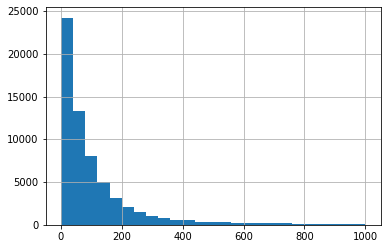

In [26]:
diff_timestamp_s = diff_timestamp.astype('timedelta64[s]')
diff_timestamp_s.hist(bins=25, range=(0,1000));

По распределению можно определить, что наиболее распространенная задержка между действиями до 200-400 сек, более 600 сек задержек практически нет, мы можем предположить, что сессия в приложении чаще всего не превышает 600 сек/10 мин.

In [27]:
new_session = (diff_timestamp.isnull()) | (diff_timestamp > '00:10:00.000000')

In [28]:
fin_df['session_id'] = fin_df.loc[new_session, ['id', 'date']].groupby('id').rank(method='first').astype(int)

In [29]:
fin_df['session_id'] = fin_df['session_id'].fillna(method='ffill').astype(int)

### Создадим сводную таблицу содержащую необходимые для сравнения данные пользователей

Подготовим таблицу с ифнормацией о том какие действия и сколько раз за период тестирования сделал каждый юзер

In [30]:
pivot_id = fin_df.pivot_table(index='id', columns='event', values='date', aggfunc='count').reset_index().fillna('0')

pivot_id['advert_open'] = pd.to_numeric(pivot_id['advert_open'])
pivot_id['contacts_call'] = pd.to_numeric(pivot_id['contacts_call'])
pivot_id['favorites_add'] = pd.to_numeric(pivot_id['favorites_add'])
pivot_id['map'] = pd.to_numeric(pivot_id['map'])
pivot_id['photos_show'] = pd.to_numeric(pivot_id['photos_show'])
pivot_id['search'] = pd.to_numeric(pivot_id['search'])
pivot_id['show_contacts'] = pd.to_numeric(pivot_id['show_contacts'])
pivot_id['tips_click'] = pd.to_numeric(pivot_id['tips_click'])
pivot_id['tips_show'] = pd.to_numeric(pivot_id['tips_show'])

Определим длительность каждой сессии каждого пользователя

In [31]:
session_duration = fin_df.pivot_table(index = ['id','session_id'], values = 'date', aggfunc=['first', 'last'])
session_duration['duration'] = session_duration['last'] - session_duration['first']

Определим общую длительность активности пользователя в приложении

In [32]:
total_time_use = session_duration.groupby('id')['duration'].sum()

Добавим в сводную таблицу данные об общей длительности использования приложения пользователями

In [33]:
pivot_id = pivot_id.merge(total_time_use, how='left', left_on='id', right_on='id')
pivot_id['duration_min'] = pivot_id['duration'].astype('timedelta64[m]')
del pivot_id['duration']

Добавим в сводную таблицу данные о количестве сессий пользователей

In [34]:
pivot_id = pivot_id.merge(fin_df.groupby('id')['session_id'].nunique(), how='left', left_on='id', right_on='id')
pivot_id = pivot_id.rename(columns={"session_id": "n_sessions"})

Добавим в сводную таблицу данные об источниках

In [35]:
pivot_id = pivot_id.merge(sources, how='left', left_on='id', right_on='id')

### Сводная таблица для дальнейшего анализа<a id='4-link'></a>

In [36]:
pivot_id.head()

,id,advert_open,contacts_call,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show,duration_min,n_sessions,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,29.0,46.0,4,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,2.0,0.0,33.0,18.0,11.0,0.0,0.0,116.0,10,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,24.0,1,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,0.0,0.0,6.0,0.0,17.0,0.0,0.0,4.0,33.0,10,google
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,9.0,3,yandex


#### Убрать редкие и выбивающиеся значения, и проанализировать значимость потерянных данных

In [37]:
pivot_id.describe()

,advert_open,contacts_call,favorites_add,map,photos_show,search,show_contacts,tips_click,tips_show,duration_min,n_sessions
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,1.435826,0.126019,0.330072,0.904030,2.332169,1.580247,1.054973,0.189611,9.330305,21.620778,2.956208
std,6.156880,0.765462,2.109938,3.040441,8.386409,3.778452,4.989622,1.044630,19.877676,40.082570,4.740561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,11.000000,2.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,10.000000,23.000000,3.000000
max,137.000000,17.000000,63.000000,71.000000,177.000000,68.000000,137.000000,30.000000,346.000000,818.000000,124.000000


Мы подготовили количественные данные для дальнейшего анализа, количество совершения действий колеблется от 0 до 346, что соответствует ожиданиям. Среднее время проведенное пользователями в приложении за рассматриваемый период составило 21 минуту, среднее количество сессий - 2,95. Максимум сессий - 124, максимум времени в приложении 818 минут, данные показатели значительно выше средних, но не будем пока терять надежду, что есть юзеры, для которых норма ежедневно использовать "Ненужные вещи"

# 3. Исследовательский анализ данных<a id='5-link'></a>

In [38]:
fin_df.groupby('event')['id'].nunique().sort_values(ascending=False)

event
tips_show        2801
search           1666
map              1456
photos_show      1095
show_contacts     981
advert_open       751
favorites_add     351
tips_click        322
contacts_call     213
Name: id, dtype: int64

Кооличество совершенных действий пользователей в разрезе источников

In [39]:
event_by_source = fin_df.pivot_table(index='event', columns='source', values = 'id', aggfunc='nunique')
event_by_source['total'] = event_by_source['google'] + event_by_source['yandex'] + event_by_source['other']
event_by_source['share_google'] = event_by_source['google'] / event_by_source['total']
event_by_source['share_yandex'] = event_by_source['yandex'] / event_by_source['total']
event_by_source['share_other'] = event_by_source['other'] / event_by_source['total']
del event_by_source['google'], event_by_source['yandex'], event_by_source['other'], event_by_source['total']

Распределение совершаемых действий (%) по типам первоначального источника траффика

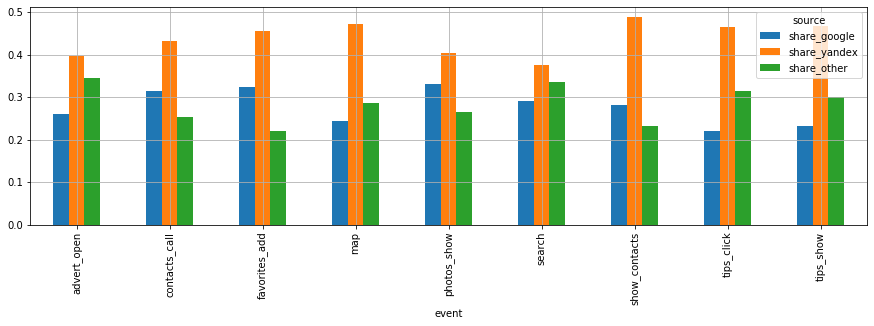

In [40]:
event_by_source.plot(kind='bar', figsize=(15,4), grid=True);

По предварительной оценке можно выделить следующие инсайты:
* по каждому из типов действий превалируют пользователи с источником yandex
* источник others превалирует на google по действиям tips_show, tips_click, search, map, advert_open, однако по favorites_add, show_contact и contacts_call - выше доля google.

Косвенно можно сделать вывод о том, что пользователи из других источников активнее ищут, в то время как Google - больше действуют в части самой цели приложения - добавляют в избранное товары, смотрят контакты и совершают звонки.

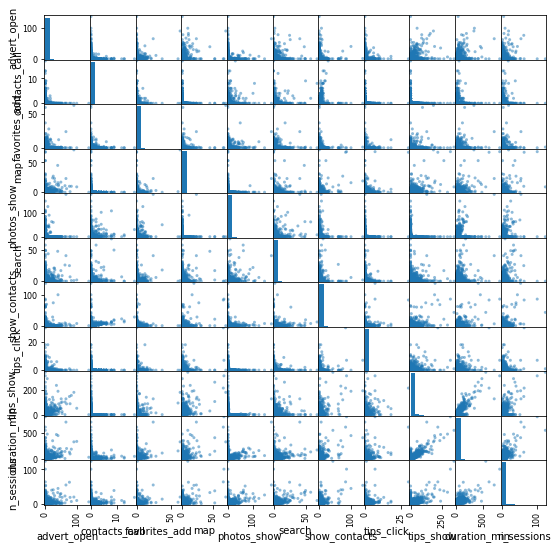

In [41]:
pd.plotting.scatter_matrix(pivot_id, figsize=(9, 9));

На основе корреляционного распределения параметров можно выделить следующие пары показателей, которые показывают связь:
* show_contacts - tips_show, duration_min, n_session

Рассчитаем CTR (показатель кликабельности) рекомендованных объявлений для использования в дальнейшем анализе

In [42]:
pivot_id['ctr'] = pivot_id['tips_click'] / pivot_id['tips_show'] * 100
pivot_id['ctr'] = pivot_id['ctr'].replace(np.inf, np.nan)
pivot_id['ctr'] = pivot_id['ctr'].fillna('0')
pivot_id['ctr'] = pd.to_numeric(pivot_id['ctr'])

Рассчитаем конверсию показателя advert_open в favorites_add для использования в дальнейшем анализе

In [43]:
pivot_id['conv_fav'] = pivot_id['favorites_add'] / pivot_id['advert_open'] * 100
pivot_id['conv_fav'] = pivot_id['conv_fav'].replace(np.inf, np.nan)
pivot_id['conv_fav'] = pivot_id['conv_fav'].fillna('0')
pivot_id['conv_fav'] = pd.to_numeric(pivot_id['conv_fav'])

Рассчитаем конверсию показателя search в advert_open для использования в дальнейшем анализе

In [44]:
pivot_id['conv_search'] = pivot_id['advert_open'] / pivot_id['search'] * 100
pivot_id['conv_search'] = pivot_id['conv_search'].replace(np.inf, np.nan)
pivot_id['conv_search'] = pivot_id['conv_search'].fillna('0')
pivot_id['conv_search'] = pd.to_numeric(pivot_id['conv_search'])

Рассчитаем конверсию показателя show_contacts в contact_call  (показатель кликабельности) рекомендованных объявлений для использования в дальнейшем анализе

In [45]:
pivot_id['conv_call'] = pivot_id['contacts_call'] / pivot_id['show_contacts'] * 100
pivot_id['conv_call'] = pivot_id['conv_call'].replace(np.inf, np.nan)
pivot_id['conv_call'] = pivot_id['conv_call'].fillna('0')
pivot_id['conv_call'] = pd.to_numeric(pivot_id['conv_call'])

Количество пользователей совершившие целевое действие - show_contacts (далее - group_A)

In [46]:
group_A = pivot_id[pivot_id['show_contacts'] != 0]
group_A['id'].count().sum()

981

Количество пользователей не совершившие целевое действие - show_contacts (далее - group_B)

In [47]:
group_B = pivot_id[pivot_id['show_contacts'] == 0]
group_B['id'].count().sum()

3312

##### Сравнение длительности пользования приложением <a id='6-link'></a>

In [48]:
group_A['duration_min'].mean()

34.76860346585117

In [49]:
group_B['duration_min'].mean()

17.72644927536232

Пользователи группы А пользовались приложением почти в 2 раза дольше.

##### Сравнение количества сессий<a id='7-link'></a>

In [50]:
group_A['n_sessions'].mean()

5.009174311926605

In [51]:
group_B['n_sessions'].mean()

2.3481280193236715

Среднее количество сессий группы А больше на 2.65

##### Сравнение долей пользователей в разрезе источников<a id='8-link'></a>

In [52]:
avg_n_sessions_A = group_A.pivot_table(index='source', values='id', aggfunc='count').sort_values(by='id', ascending=False).reset_index()
avg_n_sessions_A['share_%'] = avg_n_sessions_A['id'] / avg_n_sessions_A['id'].sum()
avg_n_sessions_A

,source,id,share_%
0,yandex,478,0.487258
1,google,275,0.280326
2,other,228,0.232416


In [53]:
avg_n_sessions_B = group_B.pivot_table(index='source', values='id', aggfunc='count').sort_values(by='id', ascending=False).reset_index()
avg_n_sessions_B['share_%'] = avg_n_sessions_B['id'] / avg_n_sessions_B['id'].sum()
avg_n_sessions_B

,source,id,share_%
0,yandex,1456,0.439614
1,other,1002,0.302536
2,google,854,0.257850


* В обеих группах большая часть пользователей пришла через yandex. В группе А - 48%, B - 44%.
* В группе А для 27,9% пользователей - источник google, 23.4% - other.
* В группе B для 25,7% пользователей - источник google, 25.7% - other.

Данный разрез не позволяет утверждать о наличии значимых различий в поведении пользователей на основании того или иного источника, однако можно заметить какой из них наиболее эффективен, может пригодиться для целей исследования других задач. 

##### Сравнение показателей по событию photo_show <a id='9-link'></a>

In [54]:
group_A['photos_show'].mean()

3.9021406727828745

In [55]:
group_B['photos_show'].mean()

1.8671497584541064

Пользователи группы A смотрят фото чаще, чем пользователи группы B

##### Сравнение CTR <a id='10-link'></a>

In [56]:
group_A['ctr'].mean()

1.4974128472215436

In [57]:
group_B['ctr'].mean()

1.2143330240319432

Кликабельность рекомендаций выше у группы совершившей целевое действие

##### Сравнение конверсий доли добавлений объявлений в избранное<a id='11-link'></a>

In [58]:
group_A['conv_fav'].mean()

8.240338048870424

In [59]:
group_B['conv_fav'].mean()

3.878295892723946

#### Сравнение конверсии действий поиска в открытие объявления <a id='12-link'></a>

In [60]:
group_A['conv_search'].mean()

35.55791663597525

In [61]:
group_B['conv_search'].mean()

30.925489771331087

Конверсия пользователей посмотревших контакты больше в 2 раза (почти).

##### Конверсия просмотров контактов в звонки<a id='13-link'></a>

In [62]:
pivot_id['conv_call'].mean()

3.5556773871387493

45% пользователей просмотревших контакты совершают звонок из приложения.

### Подготовим отдельный датафрейм пользователей совершивших целевое действие и датасет без них на базе первоначальной таблицы

In [63]:
they_saw_contacts = fin_df[fin_df['event'] == 'show_contacts']['id'].drop_duplicates()
they_saw_contacts_df = fin_df.query('id in @they_saw_contacts')

In [64]:
they_didnt_see_contacts_df = fin_df.query('id not in @they_saw_contacts')

In [65]:
they_saw_contacts_df['id'].nunique() / fin_df['id'].nunique()

0.22851153039832284

22% пользователей хотя бы раз совершили целевое действие

### DAU/WAU Общие<a id='14-link'></a>

In [66]:
dau_total = fin_df.groupby('day').agg({'id': 'nunique'}).mean()
dau_total

id    279.178571
dtype: float64

In [67]:
wau_total = fin_df.groupby('week').agg({'id': 'nunique'}).mean()
wau_total

id    1139.2
dtype: float64

In [68]:
sticky_factor1 = dau_total /wau_total *100
sticky_factor1

id    24.506546
dtype: float64

24% пользователей регулярно пользуются приложением

### DAU/WAU юзеров совершивших целевое действие<a id='15-link'></a>

Среднее кол-во уникальных пользователей в день в течение тестирования

In [69]:
dau_total1 = they_saw_contacts_df.groupby('day').agg({'id': 'nunique'}).mean()
dau_total1

id    88.392857
dtype: float64

In [70]:
wau_total1 = they_saw_contacts_df.groupby('week').agg({'id': 'nunique'}).mean()
wau_total1

id    298.4
dtype: float64

In [71]:
sticky_factor1 = dau_total1 /wau_total1 *100
sticky_factor1

id    29.622271
dtype: float64

In [72]:
dau_total1 / they_saw_contacts_df['id'].nunique()

id    0.090105
dtype: float64

9% пользователей регулярно пользуются приложением

### DAU/WAU юзеров не совершивших целевое действие<a id='16-link'></a>

In [73]:
dau_total2 = they_didnt_see_contacts_df.groupby('day').agg({'id': 'nunique'}).mean()
dau_total2

id    190.785714
dtype: float64

In [74]:
wau_total2 = they_didnt_see_contacts_df.groupby('week').agg({'id': 'nunique'}).mean()
wau_total2

id    840.8
dtype: float64

In [75]:
sticky_factor2 = dau_total2 /wau_total2 *100
sticky_factor2

id    22.690975
dtype: float64

In [76]:
dau_total2 / they_didnt_see_contacts_df['id'].nunique()

id    0.057604
dtype: float64

5.8% пользователей регулярно пользуются приложением

##### В среднем доля ежедневно пользующихся приложением людей больше на 3,2%  среди тех, кто хотя бы раз совершал целевое действие

# 4. Проверка гипотез<a id='17-link'></a>

#### Расчитаем конверсию tips_show и tips_click

Разделим датасет на 2 тестируемые группы

In [77]:
group_tips_show = pivot_id[pivot_id['tips_click'] == 0]
group_tips_click = pivot_id[pivot_id['tips_click'] != 0]

In [78]:
group_tips_click_total = group_tips_click['tips_click'].sum()
group_tips_click_total_show_contact = group_tips_click['show_contacts'].sum()

In [79]:
group_tips_show_total = group_tips_show['tips_show'].sum()
group_tips_show_total_show_contact = group_tips_show['show_contacts'].sum()

#### Проверка гипотезы: конверсия в просмотры контактов различается у этих двух групп

- **Н0: Конверсия в просмотры контактов у tips_show и tips_click не различается;**
- **H1: Конверсия в просмотры контактов у tips_show и tips_click различается**

Описанная ниже формула использует как аргументы количественные данные о событиях, совершенных пользователями двух сравниваемых групп, и возвращает значение p_value 

In [80]:
 def stat(event1_g1, event1_g2, event2_g1, event2_g2):
    
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([event1_g1, event1_g2])
    trials = np.array([event2_g1, event2_g2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(p_value)
    
    if (p_value < alpha):
        return "Отвергаем нулевую гипотезу: между долями есть значимая разница"
    else:
        return "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными" 

In [81]:
stat(group_tips_click_total_show_contact, group_tips_show_total_show_contact, group_tips_click_total, group_tips_show_total)

0.0


'Отвергаем нулевую гипотезу: между долями есть значимая разница'

По результатам проверки гипотезы можно сделать вывод, что конверсия рассматриваемых групп отличается.

#### Проверка гипотезы: Продолжительность использования приложения  пользователей нажавших кнопку show_contacts не отличается от пользователей, не сделавших этого

- **Н0: Время пользования приложением не различается;**
- **H1: Время пользования приложением различается**

Подготовим таблицы для каждой группы, в которых будет отражено общее время пользования приложением для каждого пользователя

In [82]:
alpha2 = .05
array1_2 = group_A.groupby('id')['duration_min'].sum()
array2_2 = group_B.groupby('id')['duration_min'].sum()

results2 = st.ttest_ind(array1_2, array2_2, equal_var=True)

if (results2.pvalue < alpha2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


По результатам проверки гипотезы можно сделать вывод, что общее время пользования приложением рассматриваемых групп пользователей отличается.

# 5. Описание результата работы и выводы<a id='18-link'></a>

В ходе анализа мы оценили активность пользователей в течение рассматриваемого периода, а также оценили количественные и относительные показатели пользователей в разрезе 2 групп - просмотревших контакты, и не сделавших этого.

Главным показателем влияющим на совершение целевого действия является длительность пользования приложением, чем он выше - тем лучше.

##### Показатели, по которым были проанализированы и выявлены отличия между рассматриваемыми группами

* Средняя продолжительность пользования приложением в 2 раза выше у юзеров, совершивших целевое действие.
* Среднее количество сессий на 1 пользователя посмотревшего контакты - 5, не посмотревшего - 2,34
* В среднем пользователи посмотревшие конакты в 2 раза чаще смотря изображения объявления.
* CTR целевой группы (в отношении рекомендаций) составила 1,49, в то время как у другой - 1,21.
* Целевая группа в среднем в 2 раза чаще добавляет объявленияв избранное
* В обеих группах бОльшая доля пользователей пришли в приложения через yandex, если сравнивать другие источники, то в целевой группе доля пользователей пришедшия из google больше, чем из прочих источников
* Доля пользователей ежедневно пользующихся приложением целевой группы составила 9%, другой - 5,8%.

Также мы проверили статистическую гипотезу о том, что конверсия в действие "посмотреть контакты" группы которая переходит по рекомендациям отличается, от тех кто на них не реагирует в пользу переходящих. А также убедились, что разница в общей длительности пользования в пользу целевой группы статистически значима.

#### Рекомендации
* Провести анализ и сделать более точным алгоритм предложения рекомендаций, т.к. пользователи, которые по ним переходят - чаще просматривают контакты продавца.
* Провести сегментирование пользователей на основе категорий поиска, местоположения и т.д., сформировать портрет каждого сегмента и на этой основе проанализировать наступление целевого события, т.к. разделение пользователей по факту совершения события главным образом показывает большую заинтересованность и активность целевой группы, без объяснения причин, которые на нее повлияли.

Проведенный анализ не может быть основной для принятия конкретных решений, но в то же время на его основе мы можем определить области для дальнейшего исследования, А/Б тестирования и формулирования гипотез, которые стоит проверить